In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm

In [2]:
def calculate_cumulative_variance(estimations):
    variances = np.zeros_like(estimations)
    for i in range(1, len(estimations)):
        variances[i] = np.var(estimations[:(i+1)], ddof=1) # ddof=1 daje nieobciążony estymator
    return variances

def theoretical_call_price(S_0, T, K, sg, r):
    def d_param(S_0, T, K, sg, r, plus):
        return (np.log(S_0/K) + (r+(sg**2)/2)*T)/(sg*np.sqrt(T)) if plus else (np.log(S_0/K) + (r-(sg**2)/2)*T)/(sg*np.sqrt(T))
    return S_0*norm.cdf(d_param(S_0, T, K, sg, r, True)) - K*np.exp(-r*T)*norm.cdf(d_param(S_0, T, K, sg, r, False))

def visualize_method(theoretical_prices, price_estimates, variance_estimates, strikes, method_name, second_col = True):
    plt.figure(figsize=(16,10))
    plt.subplot(2, 2, 1)
    plt.plot(price_estimates[0], label="Estimation", color="blue")
    plt.axhline(y=theoretical_prices[0], label="Theoretical value", color="red")
    plt.title(f"K = {strikes[0]} - "+method_name)
    plt.legend()
    if second_col:
        plt.subplot(2, 2, 2)
        plt.plot(variance_estimates[0], label="Variance estimation", color="blue")
        plt.title("Unbiased variance estimation")
        plt.legend()
    plt.subplot(2, 2, 3)
    plt.plot(price_estimates[1], label="Estimation", color="blue")
    plt.axhline(y=theoretical_prices[1], label="Theoretical value", color="red")
    plt.title(f"K = {strikes[1]} - "+method_name)
    plt.legend()
    if second_col:
        plt.subplot(2, 2, 4)
        plt.plot(variance_estimates[1], label="Variance estimation", color="blue")
        plt.title("Unbiased variance estimation")
        plt.legend()


# Parametry rynku

In [3]:
S_0 = 100
r = 0.1
T = 1
sg = 1
K_1 = 80
K_2 = 120
CALL_1_THEO = theoretical_call_price(S_0, T, K_1, sg, r)
CALL_2_THEO = theoretical_call_price(S_0, T, K_2, sg, r)
title1 = "K = 80"
title2 = "K = 120"

# Inicjacja losowości

In [4]:
np.random.seed(42)
n_samples = 100000
randoms = np.random.normal(0,1,n_samples)
mean_maker = np.arange(1,n_samples+1)
exponent = (sg*np.sqrt(T) * randoms) + (r - (sg**2)/2)*T
stock_prices = S_0*np.exp(exponent)

call_payoffs1 = stock_prices - K_1
call_payoffs2 = stock_prices - K_2

call_payoffs1[call_payoffs1 < 0] = 0
call_payoffs2[call_payoffs2 < 0] = 0

call_payoffs1 *= np.exp(-r*T)
call_payoffs2 *= np.exp(-r*T)


# 1. Wycena Call

## 1.0 czysta woda

In [5]:
#kalkulacja
basic_variances_1 = calculate_cumulative_variance(call_payoffs1)
basic_estimates_1 = np.cumsum(call_payoffs1)
basic_estimates_1/=mean_maker
basic_variances_2 = calculate_cumulative_variance(call_payoffs2)
basic_estimates_2 = np.cumsum(call_payoffs2)
basic_estimates_2/=mean_maker

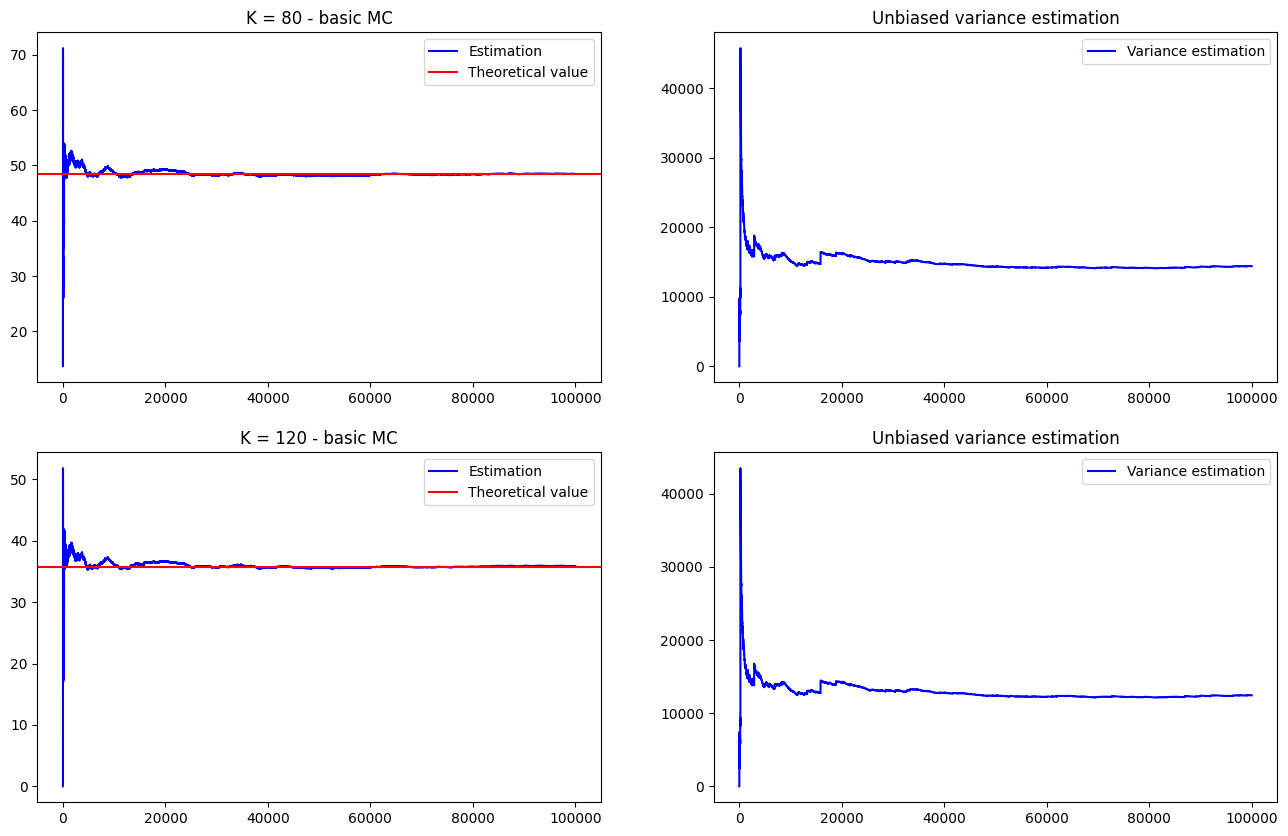

In [6]:
visualize_method([CALL_1_THEO, CALL_2_THEO], [basic_estimates_1, basic_estimates_2], [basic_variances_1,basic_variances_2], [80,120], 'basic MC')
#wykresy są bardzo podobne (w przypadku wariancji identyczne - ta sama losowość)

## 1. a) - zmienna kontrolna

In [7]:
#wartość oczekiwana zmiennej kontrolnej
b = np.exp(-r*T)
tau = S_0*np.exp(r*T)

control_variate_payoffs1 = call_payoffs1 + (tau - stock_prices) * b
control_variate_payoffs2 = call_payoffs2 + (tau - stock_prices) * b

control_variate_variances_1 = calculate_cumulative_variance(control_variate_payoffs1)
control_variate_variances_2 = calculate_cumulative_variance(control_variate_payoffs2)

control_variate_means = (np.cumsum(stock_prices) / mean_maker)

control_variate_estimates_1 = basic_estimates_1 + (tau - control_variate_means) * b
control_variate_estimates_2 = basic_estimates_2 + (tau - control_variate_means) * b

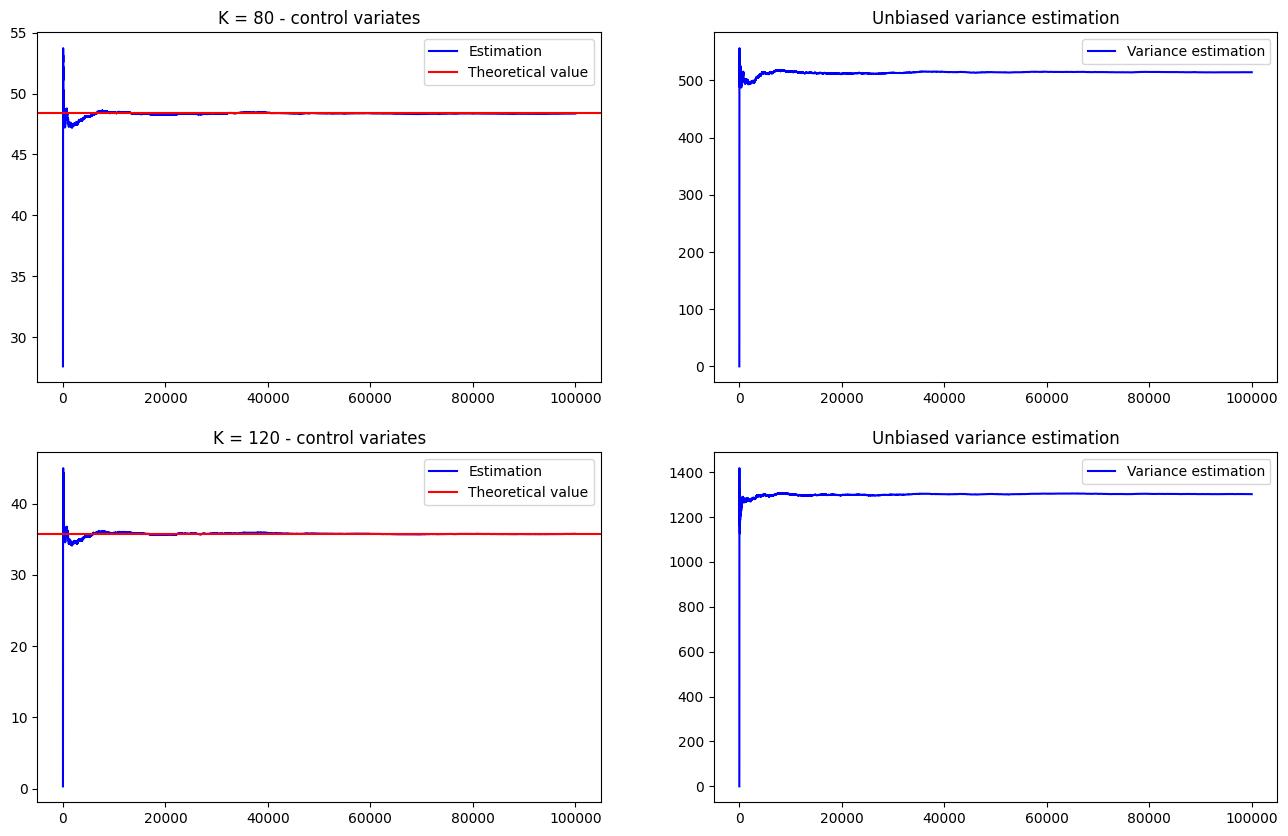

In [8]:
visualize_method([CALL_1_THEO, CALL_2_THEO], [control_variate_estimates_1, control_variate_estimates_2], [control_variate_variances_1, control_variate_variances_2], [80,120], 'control variates')

## 1. b) - zmienna kontrolna z wyestymowanym współczynnikiem

In [25]:
bs1 = []
bs2 = []
#można jakoś mądrzej to zrobić bez redundancji ale ze względu na to, że średnie się zmieniają za każdym razem nie jest to trywialne
for i in tqdm(range(1, n_samples+1)):
    centered_payoffs1 = call_payoffs1 - basic_estimates_1[i-1]
    centered_payoffs2 = call_payoffs2 - basic_estimates_2[i-1]
    centered_control_variates = stock_prices - control_variate_means[i-1]
    numerator1 = np.sum(centered_payoffs1[:i] * centered_control_variates[:i])
    numerator2 = np.sum(centered_payoffs2[:i] * centered_control_variates[:i])
    denominator = np.sum(centered_control_variates[:i]**2)
    bs1.append(numerator1 / denominator)
    bs2.append(numerator2 / denominator)

bs1 = np.array(bs1)
bs2 = np.array(bs2)

control_variate_estimated_coef_estimates1 = basic_estimates_1 + (tau - control_variate_means) * bs1
control_variate_estimated_coef_estimates2 = basic_estimates_2 + (tau - control_variate_means) * bs1

  0%|          | 0/100000 [00:00<?, ?it/s]/tmp/ipykernel_18871/2824812109.py:11: RuntimeWarning: invalid value encountered in scalar divide
  bs1.append(numerator1 / denominator)
/tmp/ipykernel_18871/2824812109.py:12: RuntimeWarning: invalid value encountered in scalar divide
  bs2.append(numerator2 / denominator)
100%|██████████| 100000/100000 [00:10<00:00, 9932.23it/s]


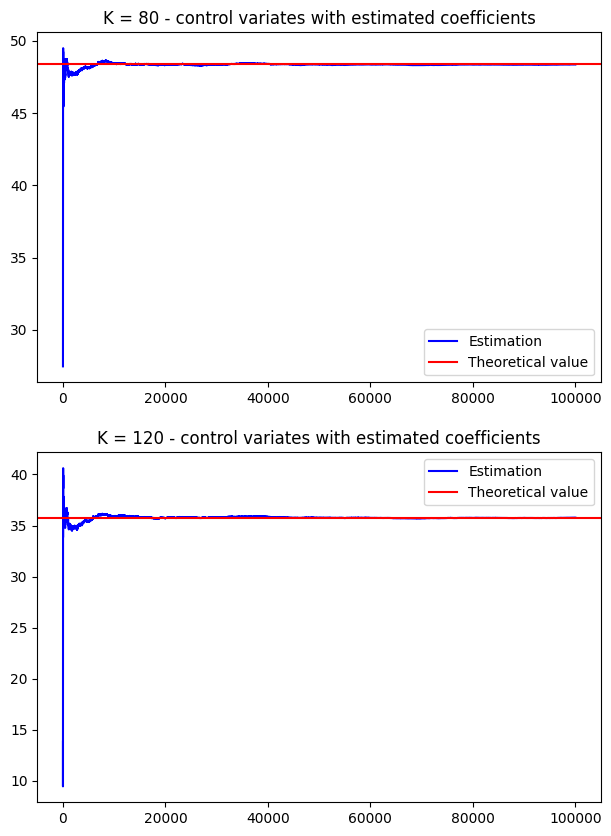

In [26]:
visualize_method([CALL_1_THEO, CALL_2_THEO], [control_variate_estimated_coef_estimates1, control_variate_estimated_coef_estimates2], [None, None], [80,120], 'control variates with estimated coefficients', False)
#w tym wypadku nie istnieje estymator z pojedynczej próbki w związku z czym nie ma wykresu wariancji

## 1. c) - zmienne antytetyczne

In [31]:
antiexponent = (sg*np.sqrt(T) * (-randoms)) + (r - (sg**2)/2)*T
antistock_prices = S_0*np.exp(antiexponent)

anticall_payoffs1 = antistock_prices - K_1
anticall_payoffs2 = antistock_prices - K_2

anticall_payoffs1[anticall_payoffs1 < 0] = 0
anticall_payoffs2[anticall_payoffs2 < 0] = 0

anticall_payoffs1 *= np.exp(-r*T)
anticall_payoffs2 *= np.exp(-r*T)

merged_payoffs1 = (anticall_payoffs1 + call_payoffs1) / 2
merged_payoffs2 = (anticall_payoffs2 + call_payoffs2) / 2

merged_variances_1 = calculate_cumulative_variance(merged_payoffs1)
merged_estimates_1 = np.cumsum(merged_payoffs1)
merged_estimates_1/=mean_maker
merged_variances_2 = calculate_cumulative_variance(merged_payoffs2)
merged_estimates_2 = np.cumsum(merged_payoffs2)
merged_estimates_2/=mean_maker

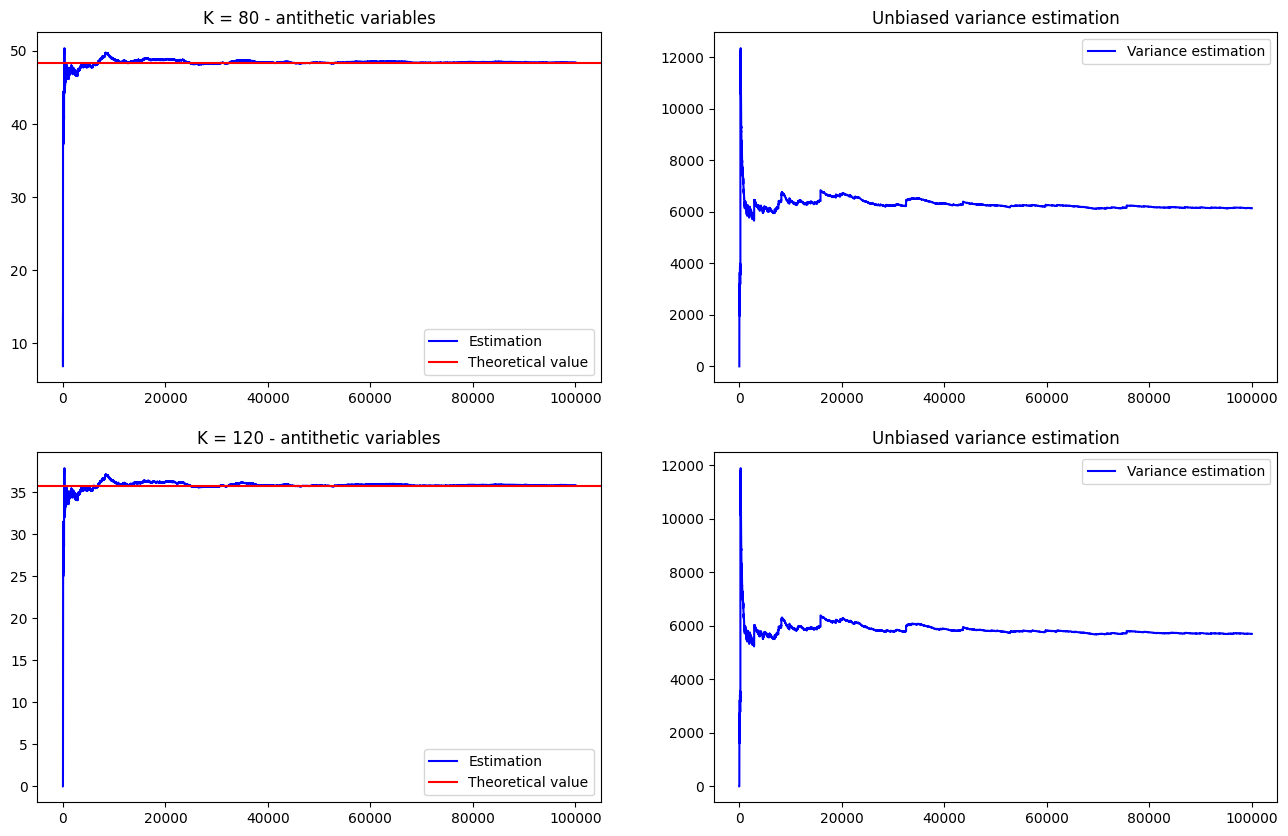

In [32]:
visualize_method([CALL_1_THEO, CALL_2_THEO], [merged_estimates_1, merged_estimates_2], [merged_variances_1, merged_variances_2], [80,120], 'antithetic variables')

## 1. e) - importance sampling

100%|██████████| 11/11 [00:49<00:00,  4.50s/it]
/tmp/ipykernel_18871/3507918406.py:28: RuntimeWarning: divide by zero encountered in log
  plt.plot(mus, np.log(imp_samp_vars1), color = "red", label = "K = 80")
/tmp/ipykernel_18871/3507918406.py:29: RuntimeWarning: divide by zero encountered in log
  plt.plot(mus, np.log(imp_samp_vars2), color = "blue", label = "K = 120")


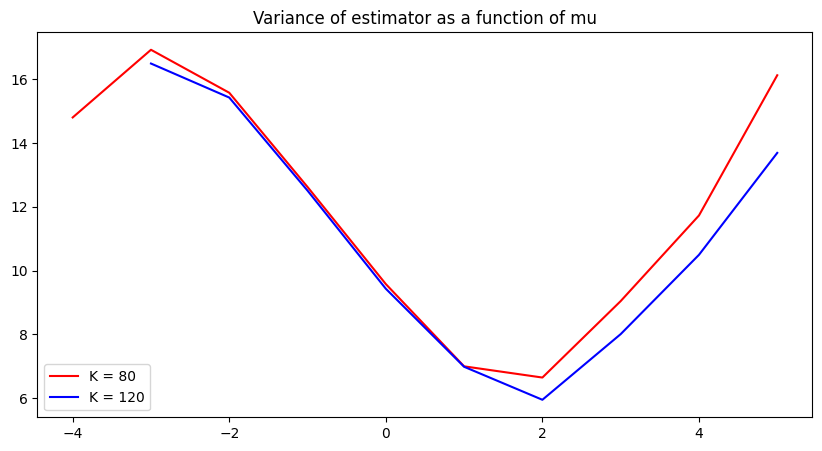

In [44]:
mus = np.linspace(-5,5,11)
imp_samp_vars1 = []
imp_samp_vars2 = []

for mu in tqdm(mus):
    Y = randoms + mu
    corrections = np.array([norm.pdf(y, 0, T) / norm.pdf(y, mu, T) for y in Y])
    exponent_Y = (sg*np.sqrt(T) * Y) + (r - (sg**2)/2)*T
    stock_prices_Y = S_0*np.exp(exponent_Y)

    call_payoffs1_Y = stock_prices_Y - K_1
    call_payoffs2_Y = stock_prices_Y - K_2

    call_payoffs1_Y[call_payoffs1_Y < 0] = 0
    call_payoffs2_Y[call_payoffs2_Y < 0] = 0

    call_payoffs1_Y *= np.exp(-r*T)
    call_payoffs2_Y *= np.exp(-r*T)

    call_payoffs1_Y *= corrections
    call_payoffs2_Y *= corrections

    imp_samp_vars1.append(np.var(call_payoffs1_Y, ddof=1))
    imp_samp_vars2.append(np.var(call_payoffs2_Y, ddof=1))
imp_samp_vars1 = np.array(imp_samp_vars1)
imp_samp_vars2 = np.array(imp_samp_vars2)
plt.figure(figsize=(10,5))
plt.plot(mus, np.log(imp_samp_vars1), color = "red", label = "K = 80")
plt.plot(mus, np.log(imp_samp_vars2), color = "blue", label = "K = 120")
plt.title("log(variance) of estimator as a function of mu")
plt.legend()

100%|██████████| 1001/1001 [1:15:31<00:00,  4.53s/it]


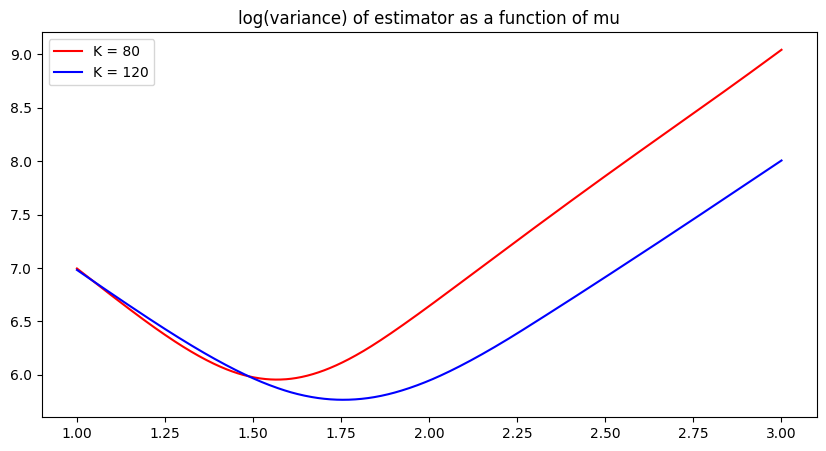

In [45]:
# dalej poszukamy między 1 a 3
mus = np.linspace(1,3,1001)
imp_samp_vars1 = []
imp_samp_vars2 = []

for mu in tqdm(mus):
    Y = randoms + mu
    corrections = np.array([norm.pdf(y, 0, T) / norm.pdf(y, mu, T) for y in Y])
    exponent_Y = (sg*np.sqrt(T) * Y) + (r - (sg**2)/2)*T
    stock_prices_Y = S_0*np.exp(exponent_Y)

    call_payoffs1_Y = stock_prices_Y - K_1
    call_payoffs2_Y = stock_prices_Y - K_2

    call_payoffs1_Y[call_payoffs1_Y < 0] = 0
    call_payoffs2_Y[call_payoffs2_Y < 0] = 0

    call_payoffs1_Y *= np.exp(-r*T)
    call_payoffs2_Y *= np.exp(-r*T)

    call_payoffs1_Y *= corrections
    call_payoffs2_Y *= corrections

    imp_samp_vars1.append(np.var(call_payoffs1_Y, ddof=1))
    imp_samp_vars2.append(np.var(call_payoffs2_Y, ddof=1))
imp_samp_vars1 = np.array(imp_samp_vars1)
imp_samp_vars2 = np.array(imp_samp_vars2)
imp_samp_vars1 = np.array(imp_samp_vars1)
imp_samp_vars2 = np.array(imp_samp_vars2)
plt.figure(figsize=(10,5))
plt.plot(mus, np.log(imp_samp_vars1), color = "red", label = "K = 80")
plt.plot(mus, np.log(imp_samp_vars2), color = "blue", label = "K = 120")
plt.title("log(variance) of estimator as a function of mu")
plt.legend()
#mu_1 ustalimy na 1.6, mu_2 na 1.8

In [42]:
norm.pdf(0)

np.float64(0.3989422804014327)

In [43]:
1/np.sqrt(2*np.pi)

np.float64(0.3989422804014327)